In [1]:
import pysindy as ps
from data._main import get_dataset
from omegaconf import OmegaConf
from utils import NEURONS_302
import numpy as np
from tests.leandro.plots import *
from sklearn.preprocessing import MinMaxScaler
from tests.leandro.plots import *
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from pysindy.utils import lorenz, lorenz_control, enzyme
import pysindy as ps

import warnings
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)

# Testing PySINDy
---

*Code from their examples just to check if it's working*

In [2]:
# Seed the random number generators for reproducibility
np.random.seed(100)

# Initialize integrator keywords for solve_ivp to replicate the odeint defaults
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

In [3]:
# define the testing and training Lorenz data we will use for these examples
dt = 0.002

t_train = np.arange(0, 10, dt)
x0_train = [-8, 8, 27]
t_train_span = (t_train[0], t_train[-1])
x_train = solve_ivp(
    lorenz, t_train_span, x0_train, t_eval=t_train, **integrator_keywords
).y.T

t_test = np.arange(0, 15, dt)
t_test_span = (t_test[0], t_test[-1])
x0_test = np.array([8, 7, 15])
x_test = solve_ivp(
    lorenz, t_test_span, x0_test, t_eval=t_test, **integrator_keywords
).y.T

# define the testing and training data for the Lorenz system with control
def u_fun(t):
    return np.column_stack([np.sin(2 * t), t ** 2])


x_train_control = solve_ivp(
    lorenz_control,
    t_train_span,
    x0_train,
    t_eval=t_train,
    args=(u_fun,),
    **integrator_keywords
).y.T
u_train_control = u_fun(t_train)
x_test_control = solve_ivp(
    lorenz_control,
    t_test_span,
    x0_test,
    t_eval=t_test,
    args=(u_fun,),
    **integrator_keywords
).y.T
u_test_control = u_fun(t_test)

In [4]:
# Instantiate and fit the SINDy model
feature_names = ['x', 'y', 'z']
sparse_regression_optimizer = ps.STLSQ(threshold=0.4)  # default is lambda = 0.1
model = ps.SINDy(feature_names=feature_names, optimizer=sparse_regression_optimizer)
model.fit(x_train, t=dt)
model.print()

(x)' = -9.999 x + 9.999 y
(y)' = 27.992 x + -0.999 y + -1.000 x z
(z)' = -2.666 z + 1.000 x y


# Synthetic Data
---

In [6]:
# Load synthetic data
data = np.load('/home/lrvnc/projects/worm-graph/tests/leandro/data/synthetic_data.npz')
x = data['h']
J = data['J']
t = data['time']

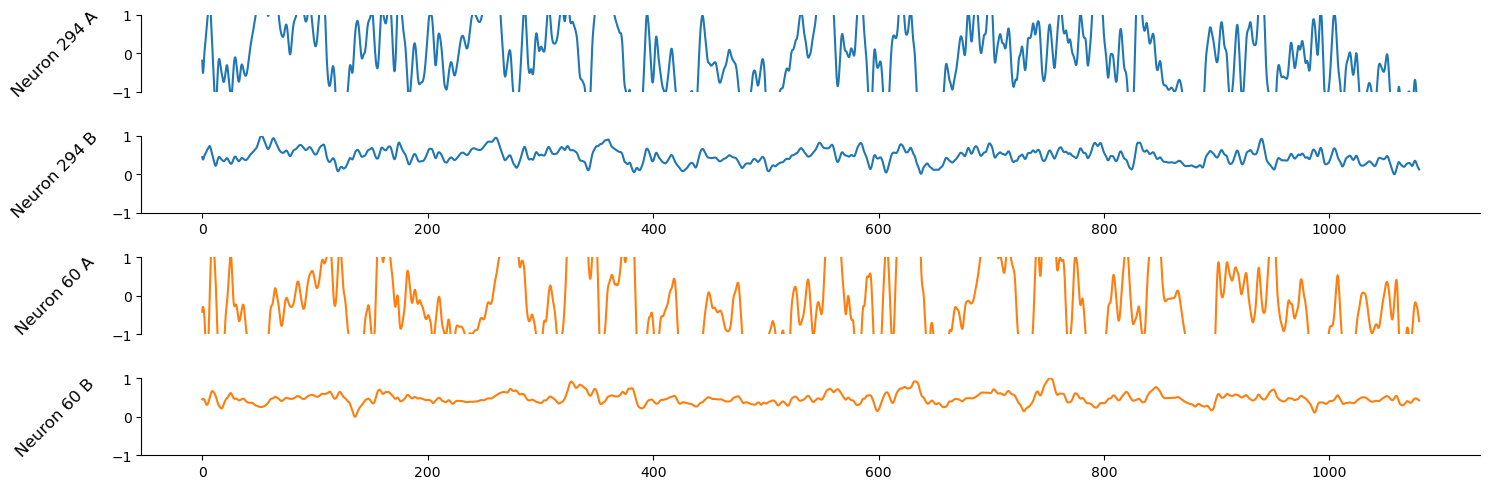

In [7]:
scaler = MinMaxScaler()
scaler.fit(x)
scaled_x = scaler.transform(x)
compare_signals(x, scaled_x, t, 2)

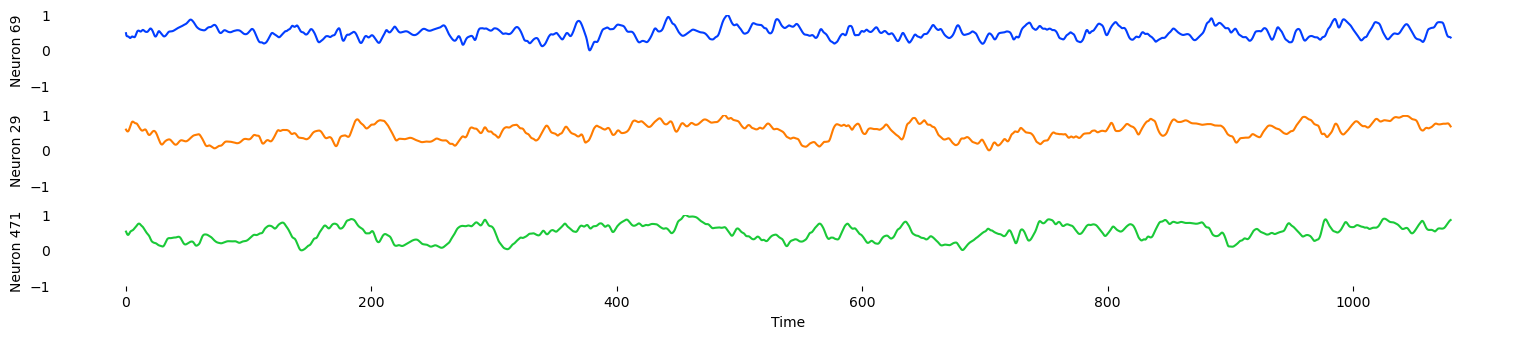

In [8]:
plot_signals(torch.from_numpy(scaled_x), torch.from_numpy(t), 3)

In [9]:
num_neurons = 4
feature_names = ['x'+str(i) for i in range(num_neurons)]
sparse_regression_optimizer = ps.STLSQ(threshold=0)  # default is lambda = 0.1
model = ps.SINDy(feature_names=feature_names, optimizer=sparse_regression_optimizer)
model.fit(scaled_x[:,:num_neurons], t=0.1)
sim_x = model.simulate(scaled_x[0,:num_neurons], t=t)
model.print()

(x0)' = -0.023 1 + -0.008 x0 + -0.048 x1 + 0.100 x2 + -0.001 x3 + 0.080 x0^2 + -0.003 x0 x1 + 0.129 x0 x2 + -0.240 x0 x3 + 0.044 x1^2 + -0.035 x1 x2 + 0.067 x1 x3 + -0.099 x2^2 + -0.020 x2 x3 + 0.080 x3^2
(x1)' = 0.048 1 + -0.103 x0 + 0.020 x1 + -0.010 x2 + -0.121 x3 + -0.117 x0^2 + 0.018 x0 x1 + 0.229 x0 x2 + 0.095 x0 x3 + 0.008 x1^2 + -0.060 x1 x2 + 0.012 x1 x3 + -0.084 x2^2 + 0.100 x2 x3 + 0.029 x3^2
(x2)' = 0.046 1 + -0.073 x0 + -0.061 x1 + -0.104 x2 + 0.071 x3 + -0.011 x0^2 + 0.006 x0 x1 + -0.022 x0 x2 + 0.082 x0 x3 + 0.051 x1^2 + 0.127 x1 x2 + -0.155 x1 x3 + 0.015 x2^2 + 0.048 x2 x3 + -0.017 x3^2
(x3)' = 0.014 1 + -0.082 x0 + -0.017 x1 + -0.024 x2 + 0.080 x3 + 0.289 x0^2 + -0.182 x0 x1 + 0.089 x0 x2 + -0.241 x0 x3 + 0.048 x1^2 + 0.053 x1 x2 + 0.001 x1 x3 + -0.055 x2^2 + -0.020 x2 x3 + 0.039 x3^2


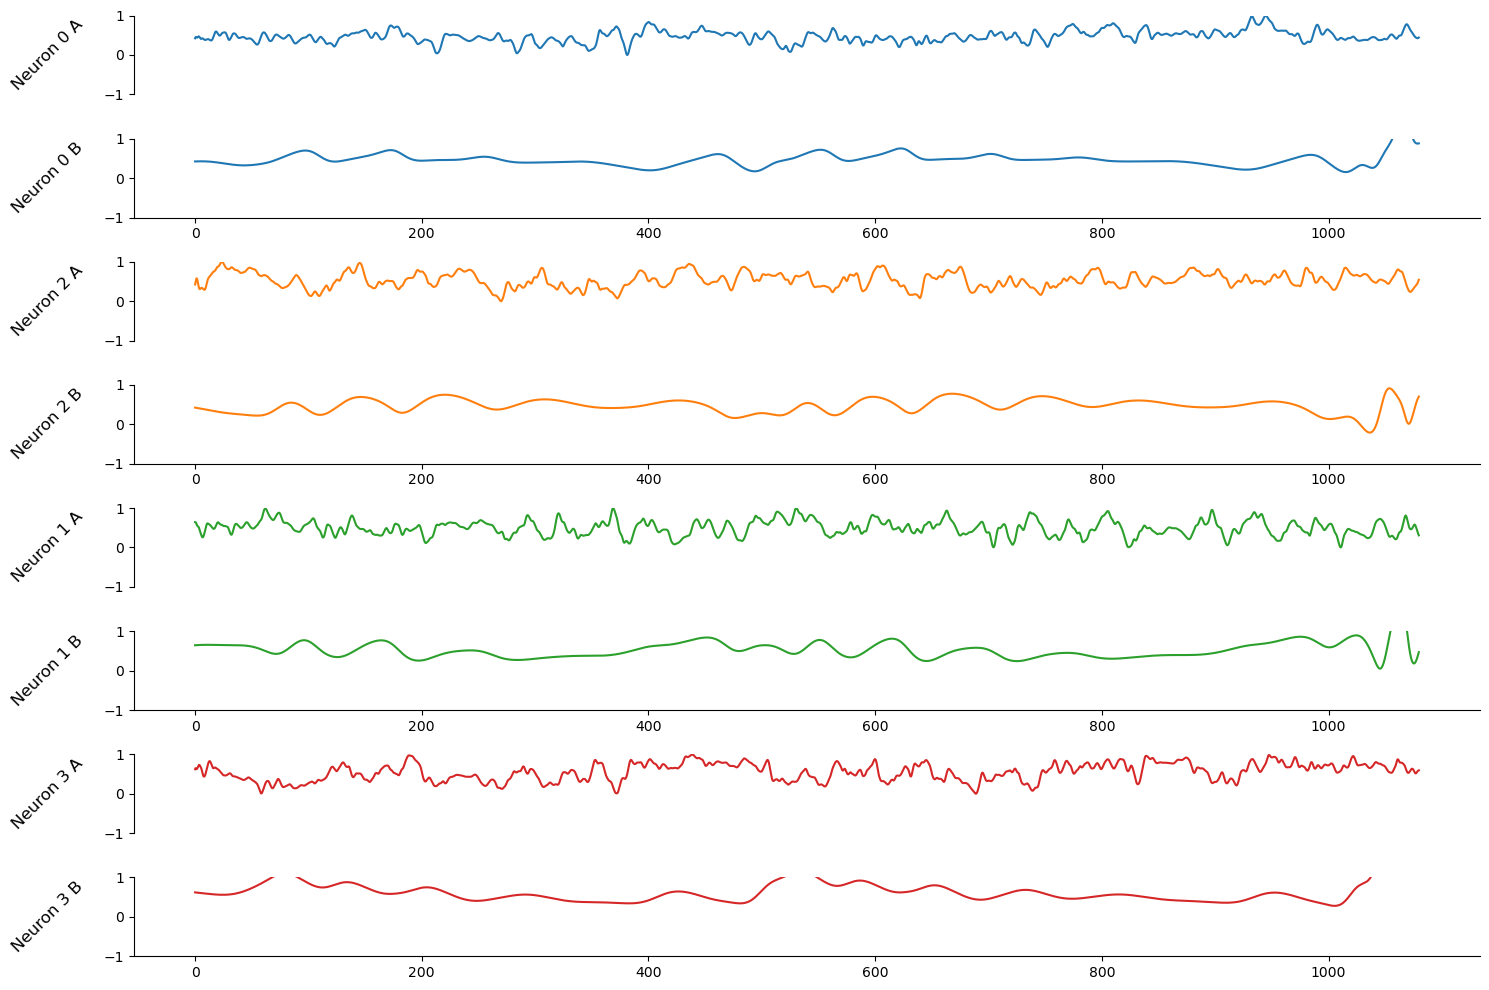

In [10]:
compare_signals(scaled_x[:,:num_neurons], sim_x, t, num_neurons)